In [234]:
import copy
import time
import gc
import ray
import os
import shutil
import numpy as np
import pandas as pd
from graphillion import setset, GraphSet
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from mfd_dynamics import MFD_Dynamics
from parameters_ndp import Parameters
from reconf_horizon import ReconfigZDD_MPC

noise_scale = 1/20
seq_interval = 60 # min. 遷移のステップ幅

def compute_cost(sim):
    cost = np.array(sim.throughput_list).sum() + np.array(sim.throughput_background_list).sum()
    #cost = -sim.cost_func_evac.risk_people(sim.x, sim.non_evac_Q.sum(axis=1))
    return cost

# No policy

In [235]:
params = Parameters()
original_capacity = copy.deepcopy(params.max_boundary_capacity)
num_zones = params.num_zones
link_indices = [(i, j) for i in range(num_zones) for j in range(num_zones) if params.adj_matrix[i, j] == 1]

output_path = f'../../output/mpc/green_{params.green_split}/{params.demand}/{params.demand_variation}/back{params.background_ratio}/{int(params.simulation_start_time/60)}_{int(params.simulation_end_time/60)}'
sim_no = MFD_Dynamics(params, output_path=None)

# prepare_noise
np.random.seed(42)
steps = sim_no.sim_end_step - sim_no.sim_start_step
noise_x = noise_scale * np.random.normal(0, 1, size=(steps, *sim_no.x.shape))
noise_x_background = noise_scale * np.random.normal(0, 1, size=(steps, *sim_no.x_background.shape))

sim_no.reset()
for t in range(sim_no.sim_start_step, sim_no.sim_end_step):
    # 摂動を与える
    sim_no.step_simulation(noise_x[t - sim_no.sim_start_step], noise_x_background[t - sim_no.sim_start_step])

#sim.plot_accumulation()
#sim.plot_mfd()
#sim.plot_mfd_animation()
#sim.plot_time()
#sim.plot_throughput()
#sim.plot_jam("../../data/processed/zone_polygon.geojson")
print(f"Cost with no policy: {compute_cost(sim_no)}")

Number of edges in the original SUMO graph: 12799
Number of nodes in the networkx graph: 5528
Number of edges in the networkx graph: 12674
Created graphs successfully
Cost with no policy: 56839.38912078305


# Greedy policy

In [236]:
output_path = f'../../output/mfd_dynamics/green_{params.green_split}/{params.demand}/{params.demand_variation}/back{params.background_ratio}/{int(params.simulation_start_time/60)}_{int(params.simulation_end_time/60)}_greedy'
sim_gr = MFD_Dynamics(params, output_path=None)
params.max_boundary_capacity = copy.deepcopy(original_capacity)
contraflow_seq = np.loadtxt(f"../../output/mpc/noise1_20/greedy/contraflow_graphs.csv", delimiter=",")

for t in range(sim_gr.sim_start_step, sim_gr.sim_end_step):
    if ((sim_gr.step % seq_interval) == 0) and (sim_gr.step < (sim_gr.sim_start_step + contraflow_seq.shape[0]*60)):
        # キャパシティを元に戻す
        sim_gr.params.max_boundary_capacity = copy.deepcopy(original_capacity)
        # コントラフローのリンクを取得
        contraflow_idx = contraflow_seq[(sim_gr.step // seq_interval) - (sim_gr.sim_start_step // seq_interval),:]
        # 個体(individual)に基づいてリンクキャパシティを調整
        for i, j in [link_indices[idx] for idx in np.where(contraflow_idx == 1)[0]]:
            # 対向車線にする
            sim_gr.params.max_boundary_capacity[i, j] *= params.contra_ratio
            sim_gr.params.max_boundary_capacity[j, i] *= (2 - params.contra_ratio)
    
    # 摂動を与える
    sim_gr.step_simulation(noise_x[t - sim_gr.sim_start_step], noise_x_background[t - sim_gr.sim_start_step])
    
#sim.plot_accumulation()
#sim.plot_mfd()
#sim.plot_mfd_animation()
#sim.plot_time()
#sim.plot_throughput()
#sim.plot_jam("../../data/processed/zone_polygon.geojson")

print(f"Cost with best policy: {compute_cost(sim_gr)}")

Cost with best policy: 57150.74984010055


# MPC (horizon 4h)

In [237]:
output_path = f'../../output/mfd_dynamics/green_{params.green_split}/{params.demand}/{params.demand_variation}/back{params.background_ratio}/{int(params.simulation_start_time/60)}_{int(params.simulation_end_time/60)}_mpc4'
sim_mpc4 = MFD_Dynamics(params, output_path=None)
params.max_boundary_capacity = copy.deepcopy(original_capacity)
contraflow_seq = np.loadtxt(f"../../output/mpc/noise1_20/mpc_horizon4/contraflow_graphs.csv", delimiter=",")

for t in range(sim_mpc4.sim_start_step, sim_mpc4.sim_end_step):
    if ((sim_mpc4.step % seq_interval) == 0) and (sim_mpc4.step < (sim_mpc4.sim_start_step + contraflow_seq.shape[0]*60)):
        # キャパシティを元に戻す
        sim_mpc4.params.max_boundary_capacity = copy.deepcopy(original_capacity)
        # コントラフローのリンクを取得
        contraflow_idx = contraflow_seq[(sim_mpc4.step // seq_interval) - (sim_mpc4.sim_start_step // seq_interval),:]
        # 個体(individual)に基づいてリンクキャパシティを調整
        for i, j in [link_indices[idx] for idx in np.where(contraflow_idx == 1)[0]]:
            # 対向車線にする
            sim_mpc4.params.max_boundary_capacity[i, j] *= params.contra_ratio
            sim_mpc4.params.max_boundary_capacity[j, i] *= (2 - params.contra_ratio)
    
    # 摂動を与える
    sim_mpc4.step_simulation(noise_x[t - sim_mpc4.sim_start_step], noise_x_background[t - sim_mpc4.sim_start_step])
    
#sim.plot_accumulation()
#sim.plot_mfd()
#sim.plot_mfd_animation()
#sim.plot_time()
#sim.plot_throughput()
#sim.plot_jam("../../data/processed/zone_polygon.geojson")

print(f"Cost with best policy: {compute_cost(sim_mpc4)}")

Cost with best policy: 65621.88999394482


# MPC (horizon 6h)

In [238]:
output_path = f'../../output/mfd_dynamics/green_{params.green_split}/{params.demand}/{params.demand_variation}/back{params.background_ratio}/{int(params.simulation_start_time/60)}_{int(params.simulation_end_time/60)}_mpc6'
sim_mpc6 = MFD_Dynamics(params, output_path=None)
params.max_boundary_capacity = copy.deepcopy(original_capacity)
contraflow_seq = np.loadtxt(f"../../output/mpc/noise1_20/mpc_horizon6/contraflow_graphs.csv", delimiter=",")

for t in range(sim_mpc6.sim_start_step, sim_mpc6.sim_end_step):
    if ((sim_mpc6.step % seq_interval) == 0) and (sim_mpc6.step < (sim_mpc6.sim_start_step + contraflow_seq.shape[0]*60)):
        # キャパシティを元に戻す
        sim_mpc6.params.max_boundary_capacity = copy.deepcopy(original_capacity)
        # コントラフローのリンクを取得
        contraflow_idx = contraflow_seq[(sim_mpc6.step // seq_interval) - (sim_mpc6.sim_start_step // seq_interval),:]
        # 個体(individual)に基づいてリンクキャパシティを調整
        for i, j in [link_indices[idx] for idx in np.where(contraflow_idx == 1)[0]]:
            # 対向車線にする
            sim_mpc6.params.max_boundary_capacity[i, j] *= params.contra_ratio
            sim_mpc6.params.max_boundary_capacity[j, i] *= (2 - params.contra_ratio)
    
    # 摂動を与える
    sim_mpc6.step_simulation(noise_x[t - sim_mpc6.sim_start_step], noise_x_background[t - sim_mpc6.sim_start_step])
    
#sim.plot_accumulation()
#sim.plot_mfd()
#sim.plot_mfd_animation()
#sim.plot_time()
#sim.plot_throughput()
#sim.plot_jam("../../data/processed/zone_polygon.geojson")

print(f"Cost with best policy: {compute_cost(sim_mpc6)}")

Cost with best policy: 65719.62913712335


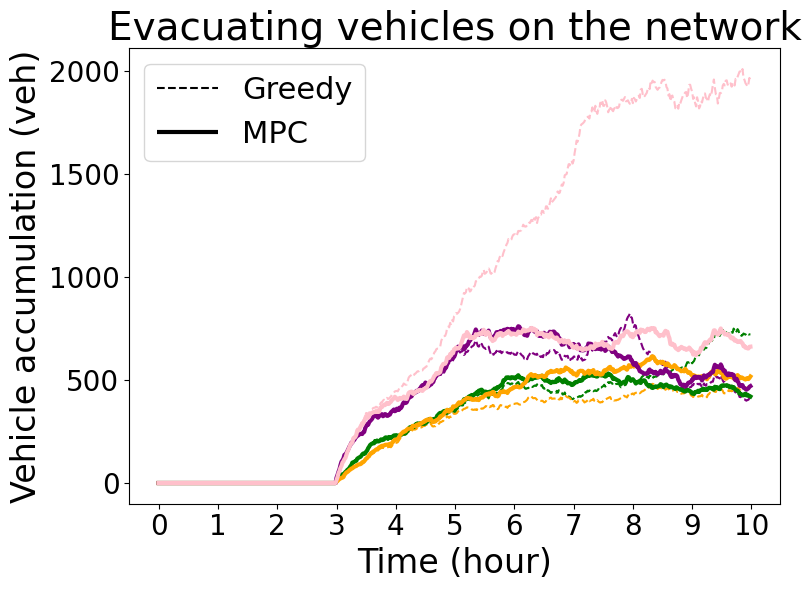

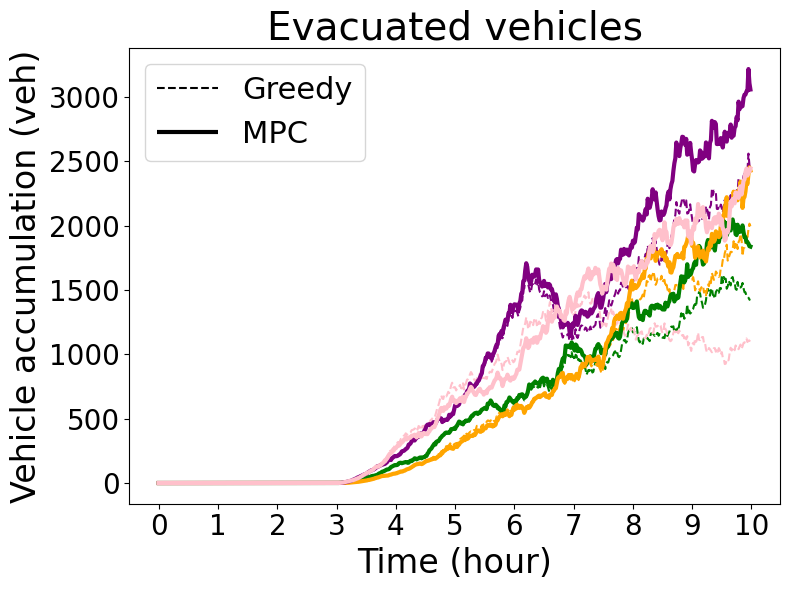

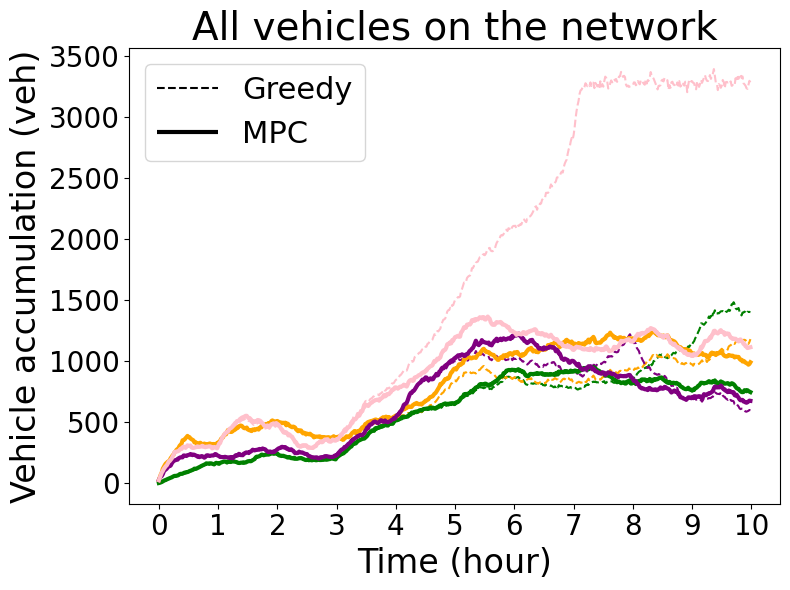

In [ ]:
output_path = "/Users/masudasatoki/Desktop/IEEE2025/manuscript/figs/calculation/large_noise"
title_fontsize = 28
label_fontsize = 24
legend_fontsize = 22
tick_fontsize = 20

def get_y_limits(data, margin=50):
    min_val = min(min(d) for d in data) - margin
    max_val = max(max(d) for d in data) + margin
    return min_val, max_val

# データを分割
def divide_x(sim):
    N_m = [x[:num_zones] for x in sim.xs]
    N_s = [x[num_zones : 2 * num_zones] for x in sim.xs]
    N_o = [x[2 * num_zones : num_zones**2 + num_zones] for x in sim.xs]
    N_p = [x[num_zones**2 + num_zones : num_zones**2 + 2 * num_zones] for x in sim.xs]
    N_d = [x[num_zones**2 + 2 * num_zones : ] for x in sim.xs]       
    N_m_background = [x[:num_zones] for x in sim.xs_background]
    N_o_background = [x[num_zones : num_zones**2] for x in sim.xs_background]
    N_p_background = [x[num_zones**2 : ] for x in sim.xs_background]
    N_o_i = [[sum(N_o[t][i * (num_zones-1) : i * (num_zones-1) + (num_zones-1)]) for i in range(num_zones)] for t in range(len(sim.xs))]
    N_d_i = [[sum(N_d[t][i * (num_zones-1) : i * (num_zones-1) + (num_zones-1)]) for i in range(num_zones)] for t in range(len(sim.xs))]
    N_o_background_i = [[sum(N_o_background[t][i * (num_zones-1) : i * (num_zones-1) + (num_zones-1)]) for i in range(num_zones)] for t in range(len(sim.xs))]

    return N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i

# Plot
tgrid = [sim_no.sampling_time * k / 60 for k in range(len(sim_no.xs))]
#tgrid = [k/60 for k in range(sim_no.sim_start_step, sim_no.sim_end_step, sim_no.sampling_time)]

N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i = divide_x(sim_no)
N = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] for i in range(len(N_m))]
N_all = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] + N_m_background[i] + N_o_background_i[i] for i in range(len(N_m))]
N_o_total = [N_o[i] + N_o_background[i] for i in range(len(N_o))]
data_no = [N, N_p, N_all, N_o_total]

N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i = divide_x(sim_gr)
N = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] for i in range(len(N_m))]
N_all = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] + N_m_background[i] + N_o_background_i[i] for i in range(len(N_m))]
N_o_total = [N_o[i] + N_o_background[i] for i in range(len(N_o))]
data_gr = [N, N_p, N_all, N_o_total]

N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i = divide_x(sim_mpc4)
N = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] for i in range(len(N_m))]
N_all = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] + N_m_background[i] + N_o_background_i[i] for i in range(len(N_m))]
N_o_total = [N_o[i] + N_o_background[i] for i in range(len(N_o))]
data_mpc4 = [N, N_p, N_all, N_o_total]

N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i = divide_x(sim_mpc6)
N = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] for i in range(len(N_m))]
N_all = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] + N_m_background[i] + N_o_background_i[i] for i in range(len(N_m))]
N_o_total = [N_o[i] + N_o_background[i] for i in range(len(N_o))]
data_mpc6 = [N, N_p, N_all, N_o_total]

# グラフを描画
titles = ['Evacuating vehicles on the network', 'Evacuated vehicles', 'All vehicles on the network']
line_styles = ['--', '-']
line_widths = [1.5, 3]
data_list = [data_gr, data_mpc6]
use_zones = [1,4,5,6]

for ns in range(3):
    data = [data_list[0][ns], data_list[1][ns]]#, data_list[2][0], data_list[3][0]]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
    ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
    for i, d in enumerate(data):
        for zone_idx in use_zones:
            # 各ゾーンに対応する時系列データを抽出
            zone_data = [d[j][zone_idx] for j in range(len(d))]
            ax.plot(tgrid, zone_data, color=params.color_dict[zone_idx], linestyle=line_styles[i], linewidth=line_widths[i])
    ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
    ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
    ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
    ax.set_ylabel('Vehicle accumulation (veh)', fontsize=label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.legend(['Greedy', 'MPC'], ncol=1, fontsize=legend_fontsize)
    ax.set_title(titles[ns], fontsize=title_fontsize)
    ax.grid(False)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}/{titles[ns]}.png', dpi=400)
        plt.show()
    else:
        plt.show()

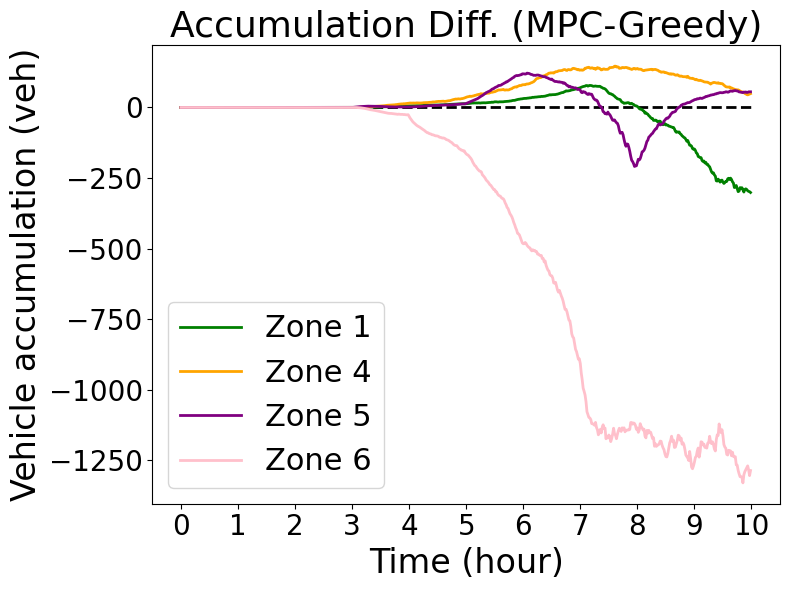

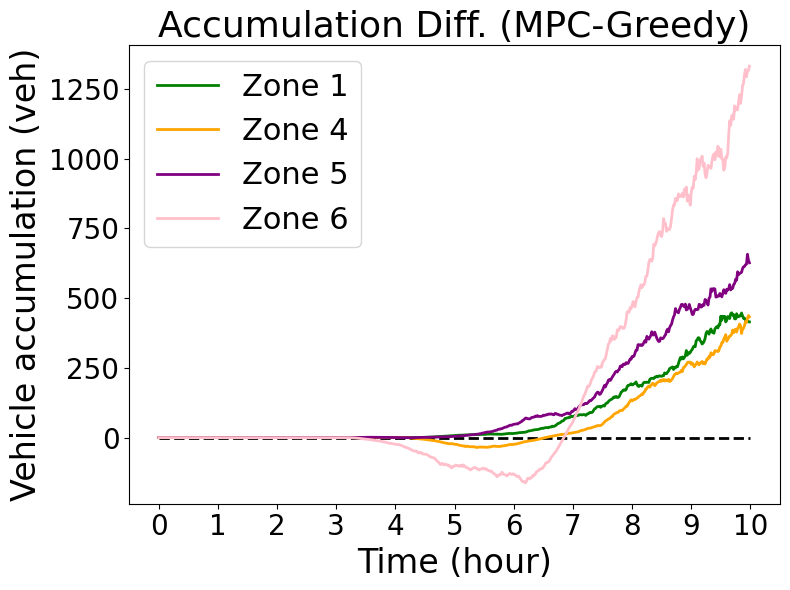

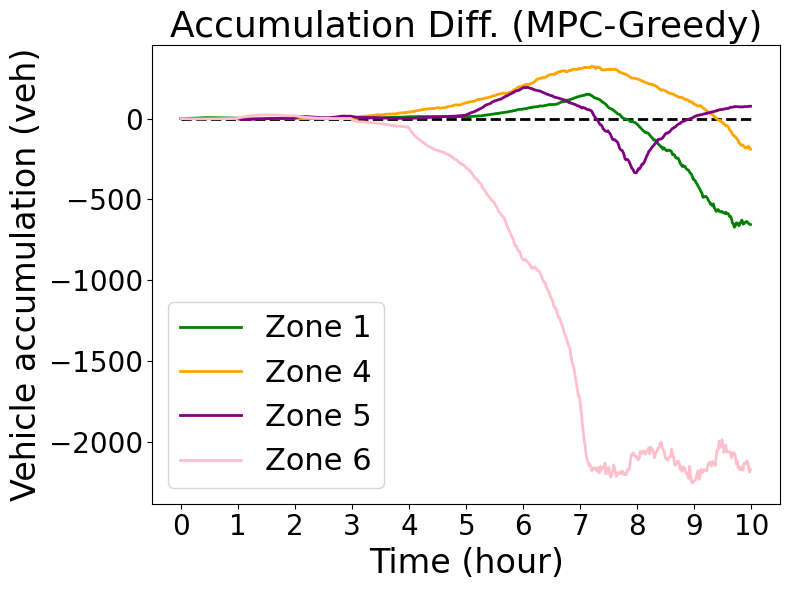

In [229]:
for ns in range(3):
    dif = [data_list[1][ns][i] - data_list[0][ns][i] for i in range(len(data_list[0][ns]))]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hlines(y=0, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle='--', linewidth=2)
    for zone_idx in use_zones:
        # 各ゾーンに対応する時系列データを抽出
        zone_data = [dif[j][zone_idx] for j in range(len(dif))]
        ax.plot(tgrid, zone_data, color=params.color_dict[zone_idx], linestyle='-', linewidth=2, label=f'Zone {zone_idx}')
    ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
    ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
    ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
    ax.set_ylabel('Vehicle accumulation (veh)', fontsize=label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.legend(ncol=1, fontsize=legend_fontsize)
    ax.set_title("Accumulation Diff. (MPC-Greedy)", fontsize=title_fontsize-2)
    ax.grid(False)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}/Accumulation Difference (MPC-Greedy).png', dpi=400)
        plt.show()
    else:
        plt.show()

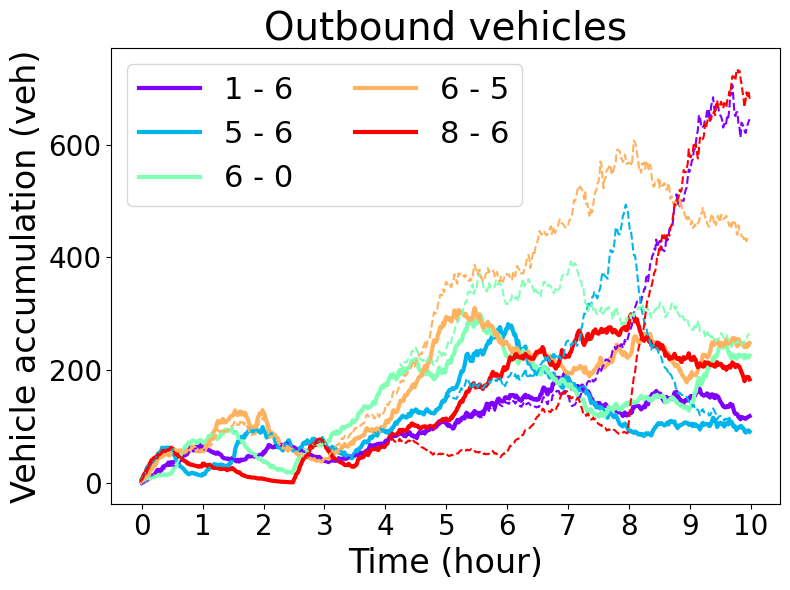

In [230]:
link_legend = []

def get_color_dict(n):
    colors = plt.cm.rainbow(np.linspace(0, 1, n))
    return {i: colors[i] for i in range(n)}

def index_to_position(n, index):
    count = 0
    for i in range(n):
        for j in range(n):
            if i != j:  # 対角成分でない場合
                if count == index:
                    return i, j
                count += 1
    return None  # 番号が範囲外の場合

link_flow = []
N_o_total = data_list[0][3]
for link in range(len(N_o[0])):
    # 各ゾーンに対応する時系列データを抽出
    link_data = [N_o_total[j][link] for j in range(len(N_o))]
    link_flow.append(sum(link_data))
link_flow = sorted(link_flow, reverse=True)


rank = 5
color_dict = get_color_dict(rank)
data = [data_list[0][3], data_list[1][3]]#, data_list[2][0], data_list[3][0]]
fig, ax = plt.subplots(figsize=(8, 6))
#ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
#ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
count = 0
for link in range(len(data[0][0])):
    link_data = [data[0][j][link] for j in range(len(data[0]))]
    if sum(link_data) > link_flow[rank]:
        link_data = [data[1][j][link] for j in range(len(data[1]))]
        ax.plot(tgrid, link_data, '-', linewidth=line_widths[1], color=color_dict[count])
        row, col = index_to_position(num_zones, link)
        link_legend.append(f'{row} - {col}')
        count += 1
ax.legend(link_legend, ncol=2, fontsize=legend_fontsize)

count = 0
for link in range(len(data[0][0])):
    link_data = [data[0][j][link] for j in range(len(data[0]))]
    if sum(link_data) > link_flow[5]:
        link_data = [data[0][j][link] for j in range(len(data[0]))] 
        ax.plot(tgrid, link_data, '--', linewidth=line_widths[0], color=color_dict[count])
        count += 1
ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
ax.set_ylabel('Vehicle accumulation (veh)', fontsize=label_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_title('Outbound vehicles', fontsize=title_fontsize)
ax.grid(False)
plt.tight_layout()
if output_path is not None:
    plt.savefig(f'{output_path}/N_o_total.png', dpi=400)
    plt.show()
else:
    plt.show()

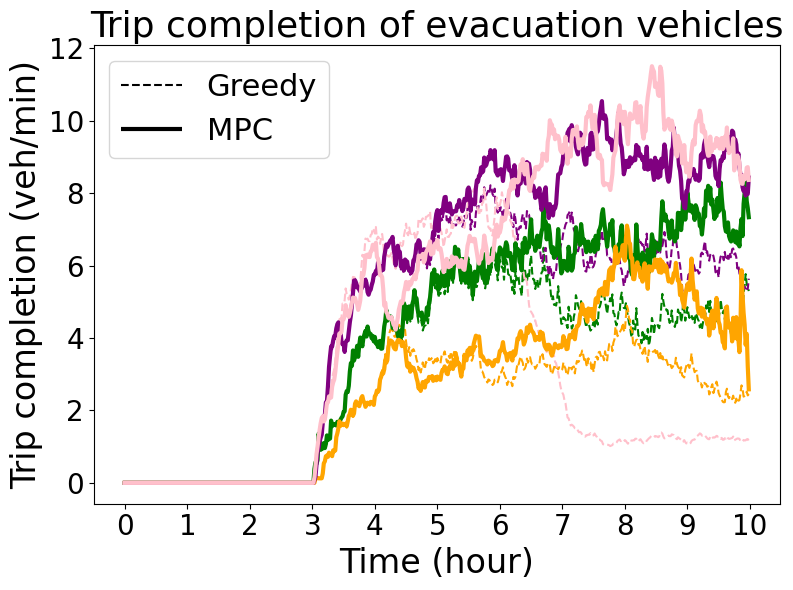

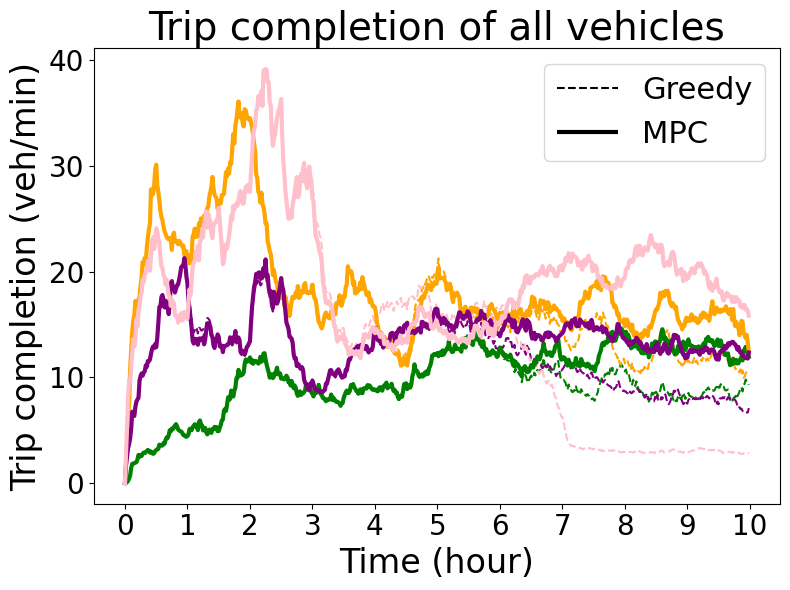

In [231]:
sim_list = [sim_gr, sim_mpc6]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
for idx, sim_to_draw in enumerate(sim_list):
    sim = copy.deepcopy(sim_to_draw)
    for i in use_zones:
        throughput = [x[i] for x in sim.throughput_list]
        ax.plot(tgrid, throughput, color=params.color_dict[i], linewidth=line_widths[idx], linestyle=line_styles[idx])
ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
ax.set_ylabel('Trip completion (veh/min)', fontsize=label_fontsize)
ax.legend(['Greedy', 'MPC'], ncol=1, fontsize=legend_fontsize)
ax.grid(False)
plt.title("Trip completion of evacuation vehicles", fontsize=26)
plt.tight_layout()
if output_path is not None:
    plt.savefig(f'{output_path}/throughput_evac.png', dpi=400)
    plt.show()
else:
    plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
for idx, sim_to_draw in enumerate(sim_list):
    sim = copy.deepcopy(sim_to_draw)
    for i in use_zones:
        throughput = [x[i]+xback[i] for x, xback in zip(sim.throughput_list, sim.throughput_background_list)]
        ax.plot(tgrid, throughput, color=params.color_dict[i], linewidth=line_widths[idx], linestyle=line_styles[idx])
ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
ax.set_ylabel('Trip completion (veh/min)', fontsize=label_fontsize)
ax.legend(['Greedy', 'MPC'], ncol=1, fontsize=legend_fontsize)
ax.grid(False)
plt.title("Trip completion of all vehicles", fontsize=title_fontsize)
plt.tight_layout()
if output_path is not None:
    plt.savefig(f'{output_path}/throughput_all.png', dpi=400)
    plt.show()
else:
    plt.show()

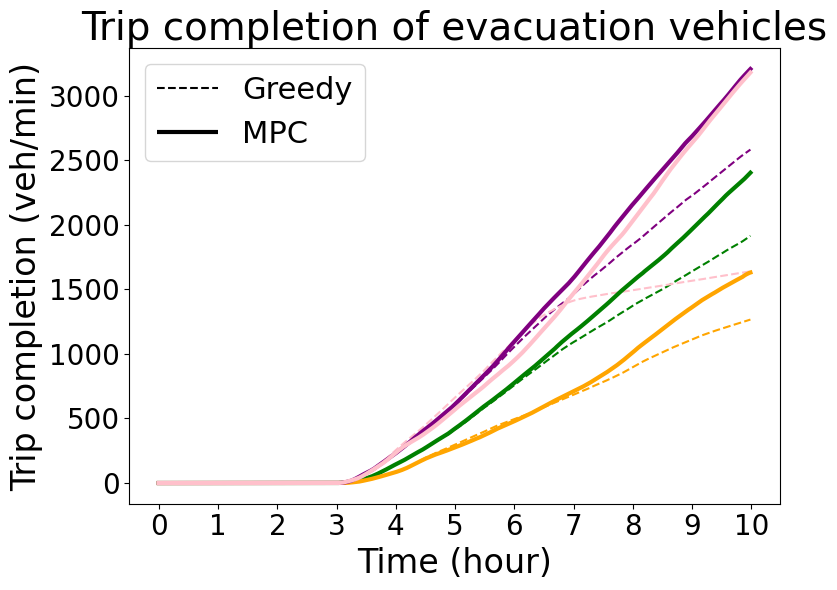

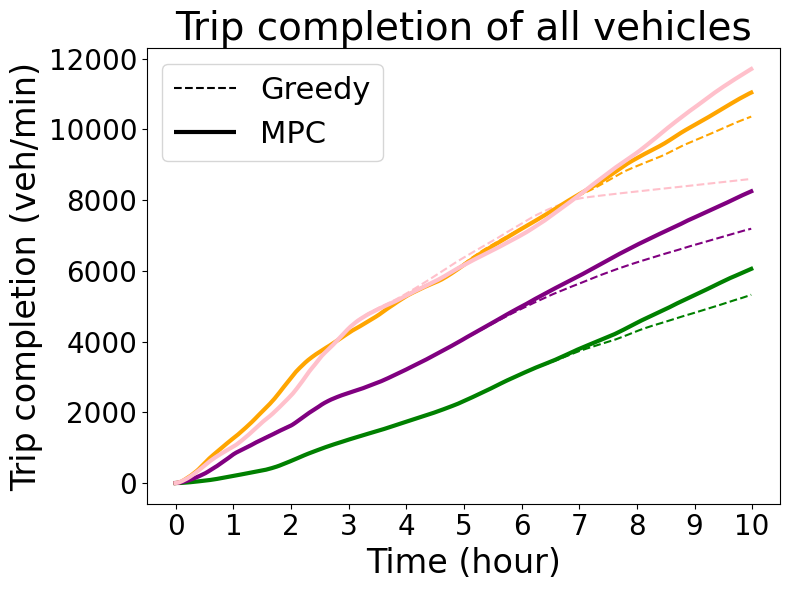

In [232]:
sim_list = [sim_gr, sim_mpc6]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
for idx, sim_to_draw in enumerate(sim_list):
    sim = copy.deepcopy(sim_to_draw)
    for i in use_zones:
        throughput = np.cumsum([x[i] for x in sim.throughput_list])
        ax.plot(tgrid, throughput, color=params.color_dict[i], linewidth=line_widths[idx], linestyle=line_styles[idx])
ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
ax.set_ylabel('Trip completion (veh/min)', fontsize=label_fontsize)
ax.legend(['Greedy', 'MPC'], ncol=1, fontsize=legend_fontsize)
ax.grid(False)
plt.title("Trip completion of evacuation vehicles", fontsize=title_fontsize)
plt.tight_layout()
if output_path is not None:
    plt.savefig(f'{output_path}/cum_throughput_evac.png', dpi=400)
    plt.show()
else:
    plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[0], linewidth=line_widths[0])
ax.hlines(y=np.inf, xmin=0, xmax=(params.simulation_end_time - params.simulation_start_time)/60, color='black', linestyle=line_styles[1], linewidth=line_widths[1])
for idx, sim_to_draw in enumerate(sim_list):
    sim = copy.deepcopy(sim_to_draw)
    for i in use_zones:
        throughput = np.cumsum([x[i]+xback[i] for x, xback in zip(sim.throughput_list, sim.throughput_background_list)])
        ax.plot(tgrid, throughput, color=params.color_dict[i], linewidth=line_widths[idx], linestyle=line_styles[idx])
ax.set_xticks(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1))
ax.set_xticklabels(np.arange(0, (params.simulation_end_time - params.simulation_start_time)/60+1, 1).astype(int), fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlabel('Time (hour)', fontsize=label_fontsize)
ax.set_ylabel('Trip completion (veh/min)', fontsize=label_fontsize)
ax.legend(['Greedy', 'MPC'], ncol=1, fontsize=legend_fontsize)
ax.grid(False)
plt.title("Trip completion of all vehicles", fontsize=title_fontsize)
plt.tight_layout()
if output_path is not None:
    plt.savefig(f'{output_path}/cum_throughput_all.png', dpi=400)
    plt.show()
else:
    plt.show()

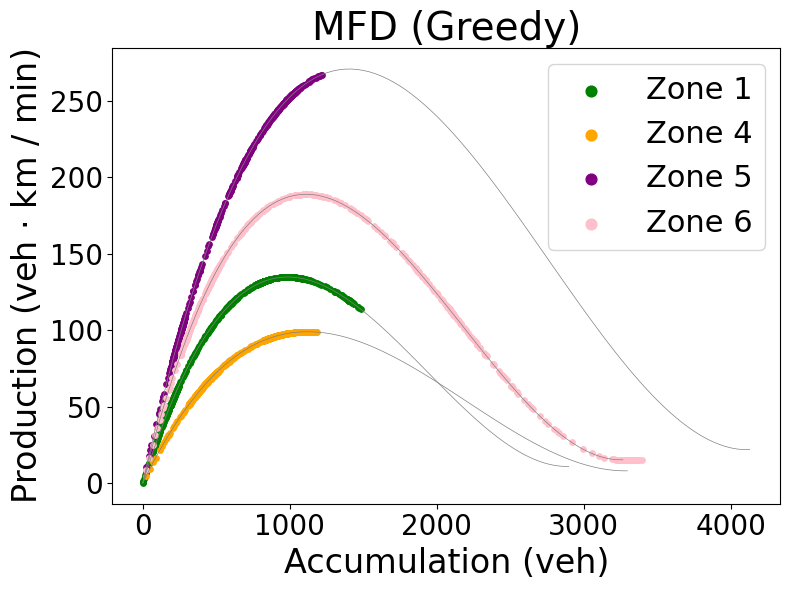

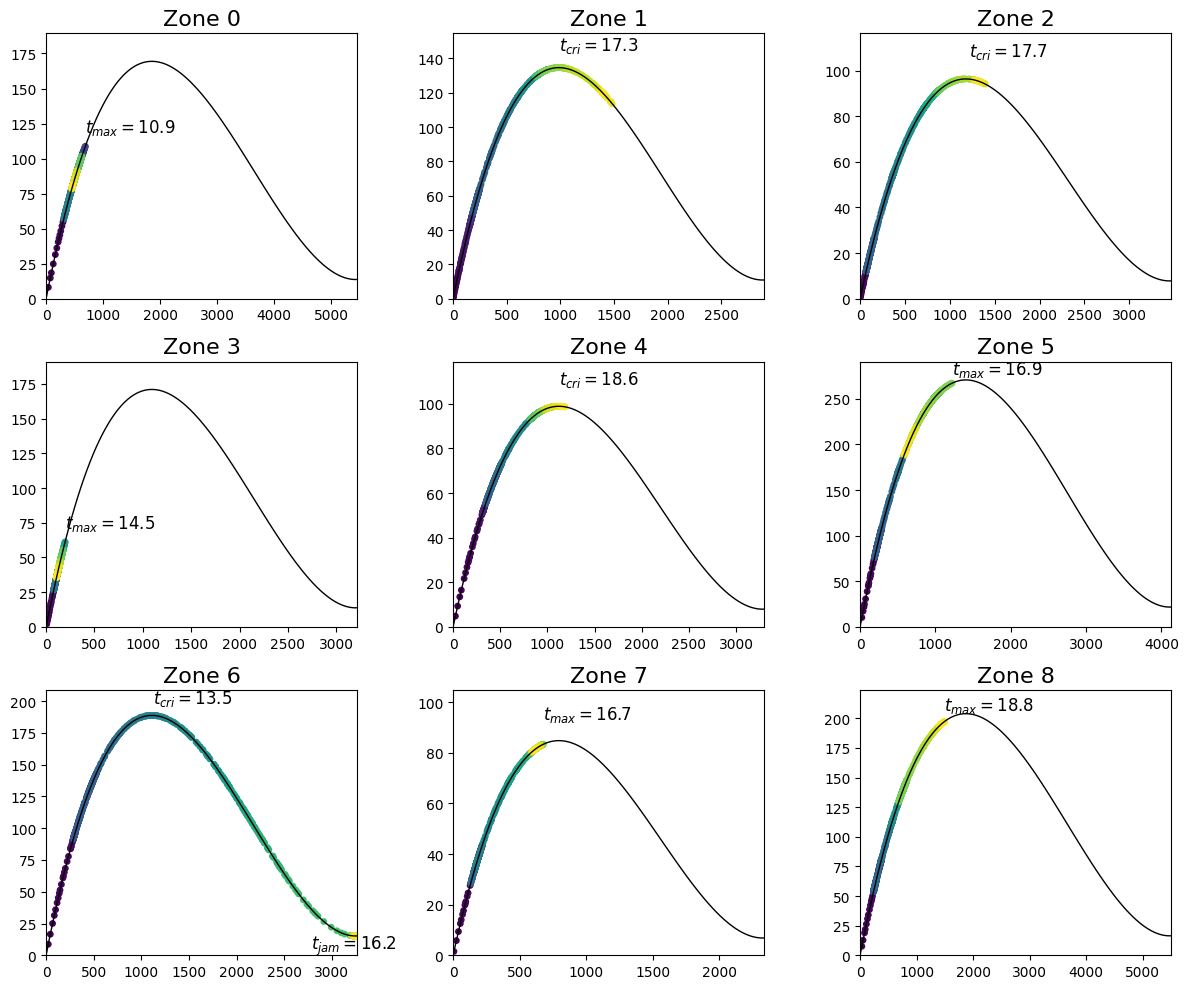

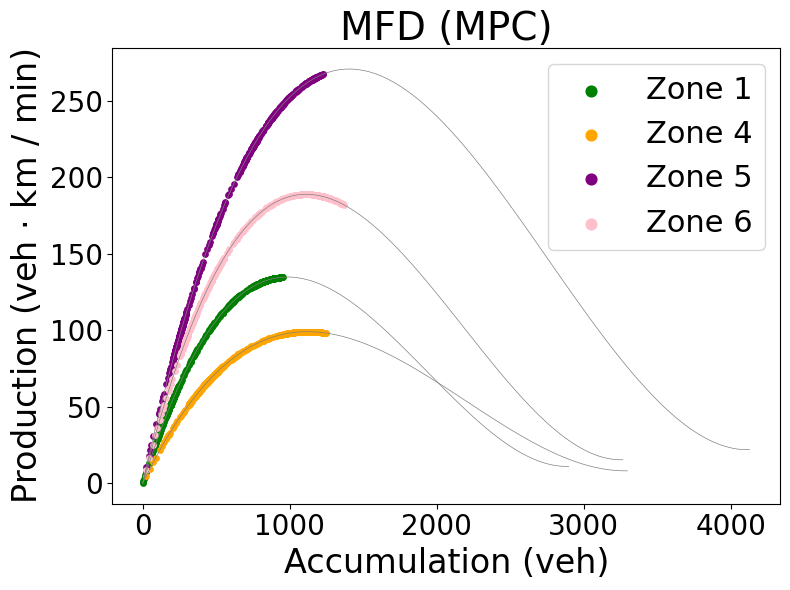

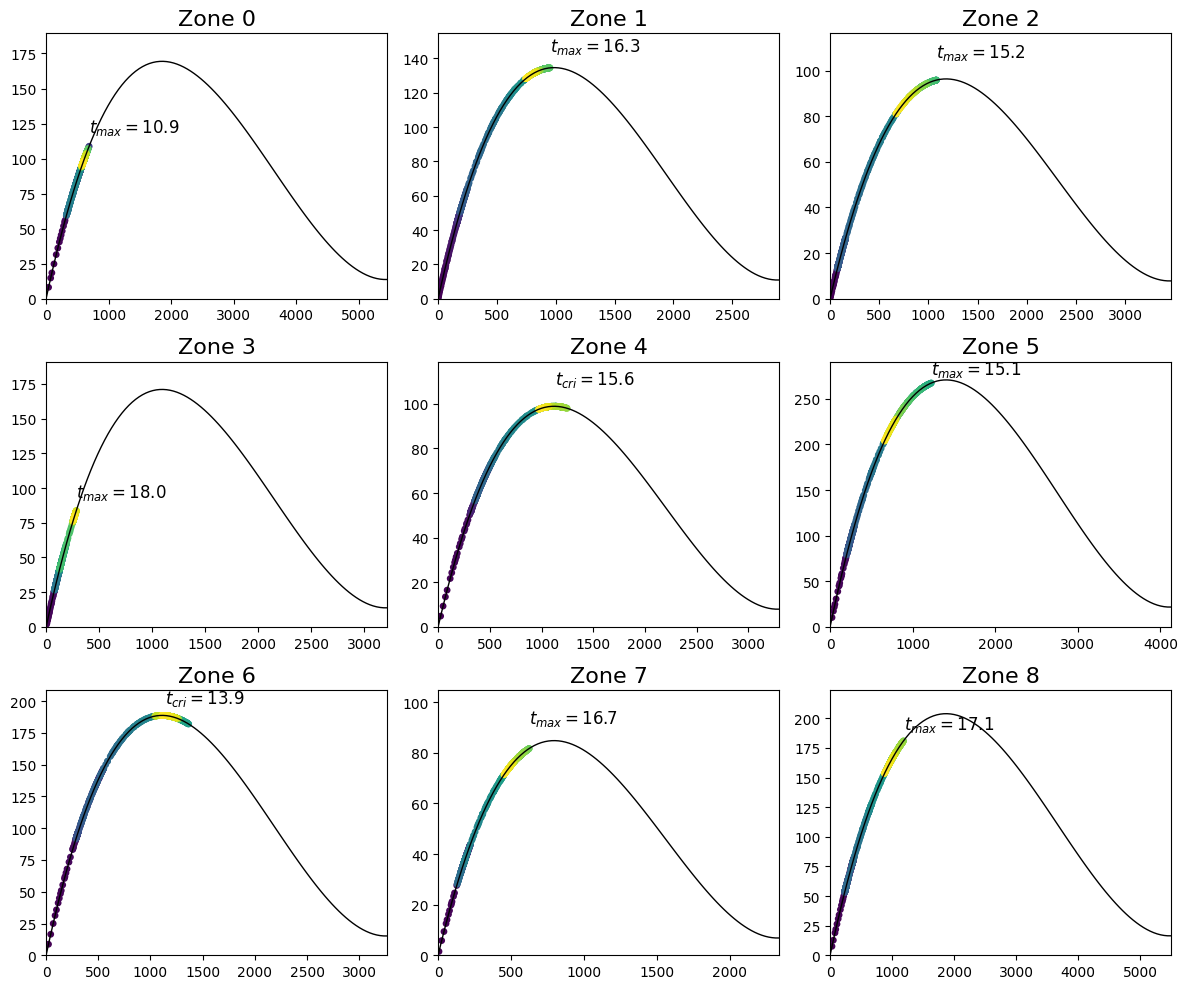

In [233]:
title = ['MFD (Greedy)', 'MFD (MPC)']
sim_list = [sim_gr, sim_mpc6]

def critical_accumulation_func():
    a, b, c = params.A, params.B, params.C
    return (-b - np.sqrt(b**2 - 3*a*c)) / (3*a)

def mfd_zone(N_zone: float, zone: int):
    N_zone = np.clip(N_zone, 0, params.N_jam[zone])
    return params.A[zone] * (N_zone**3) + params.B[zone] * (N_zone**2) + params.C[zone] * N_zone

for sim_to_draw, title_str in zip(sim_list, title):
    sim = copy.deepcopy(sim_to_draw)

    N_m, N_s, N_o, N_p, N_d, N_m_background, N_o_background, N_p_background, N_o_i, N_d_i, N_o_background_i = divide_x(sim)
    N_all = [N_m[i] + N_s[i] + N_o_i[i] + N_d_i[i] + N_m_background[i] + N_o_background_i[i] for i in range(len(N_m))]

    marker_size = 15
    alpha = 1.0
    critical_accumulation = critical_accumulation_func()

    plt.figure(figsize=(8, 6))
    plt.clf()
    for zone in use_zones:
        #mfd全体
        x = np.linspace(0, params.N_jam[zone], 100)
        y = mfd_zone(x, zone)
        #plt.xlim(0, params.N_jam[zone])
        #plt.ylim(0, max(y) + 20)
        plt.plot(x, y, color='grey', linewidth=.5)
        #mfdプロット
        x = np.array([N_all[t][zone] for t in range(len(N_m))])
        y = mfd_zone(x, zone)
        
        plt.scatter(x, y, s=marker_size, alpha=alpha, color=params.color_dict[zone], label=f'Zone {zone}')
        
        # 頂点を超えた時間を記入
        '''
        n_critical = critical_accumulation[zone]
        N_all_zone = [N_all[t][zone] for t in range(len(N_m))]
        if np.any(N_all_zone >= n_critical):
            t_c = np.argmax(N_all_zone >= n_critical)
            t_c_all = (np.argmax(N_all_zone >= n_critical)  + sim.sim_start_step )* sim.sampling_time
            plt.text(N_all[t_c][zone], mfd_zone(N_all[t_c][zone], zone) + 10, fr'$t_{{cri}}={t_c_all/60:.1f}$', fontsize=14)
        else:
            t_max = np.argmax(N_all_zone)
            t_max_all = (np.argmax(N_all_zone) + sim.sim_start_step) * sim.sampling_time
            plt.text(N_all[t_max][zone], mfd_zone(N_all[t_max][zone], zone) + 10, fr'$t_{{max}}={t_max_all/60:.1f}$', fontsize=14)
        
        if np.any(N_all_zone >= params.N_jam[zone]):
            t_jam = np.argmax(N_all_zone >= params.N_jam[zone])
            t_jam_all = (np.argmax(N_all_zone >= params.N_jam[zone]) + sim.sim_start_step) * sim.sampling_time
            plt.text(N_all[t_jam][zone]-500,  5, fr'$t_{{jam}}={t_jam_all/60:.1f}$', fontsize=14)
        '''
    plt.legend(loc='upper right', fontsize=legend_fontsize, markerscale=2)
    plt.xlabel('Accumulation (veh)', fontsize=label_fontsize)
    plt.ylabel(fr'Production (veh $\cdot$ km / min)', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.title(title_str, fontsize=title_fontsize)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}/mfd_{title_str}.png', dpi=400)
        plt.show()
    else:
        plt.show()

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    axes = axes.flatten()

    for zone in range(num_zones):
        ax = axes[zone]
        x_mfd = np.linspace(0, params.N_jam[zone], 100)
        y_mfd = mfd_zone(x_mfd, zone)
        ax.plot(x_mfd, y_mfd, color='black', linewidth=1)

        # MFDデータプロット（現在の時間までのデータ）
        x_data = np.array([N_all[t][zone] for t in range(len(N_m))])
        y_data = mfd_zone(x_data, zone)
        color = np.arange(sim.sim_start_step//60, sim.sim_end_step//60, sim.sampling_time/60)
        ax.scatter(x_data, y_data, s=marker_size, c=color, cmap='viridis', alpha=alpha)
        
        n_critical = critical_accumulation[zone]
        N_all_zone = [N_all[t][zone] for t in range(len(N_m))]
        if np.any(N_all_zone >= n_critical):
            t_c = np.argmax(N_all_zone >= n_critical)
            t_c_all = (np.argmax(N_all_zone >= n_critical)  + sim.sim_start_step )* sim.sampling_time
            ax.text(N_all[t_c][zone], mfd_zone(N_all[t_c][zone], zone) + 10, fr'$t_{{cri}}={t_c_all/60:.1f}$', fontsize=12)
        else:
            t_max = np.argmax(N_all_zone)
            t_max_all = (np.argmax(N_all_zone) + sim.sim_start_step) * sim.sampling_time
            ax.text(N_all[t_max][zone], mfd_zone(N_all[t_max][zone], zone) + 10, fr'$t_{{max}}={t_max_all/60:.1f}$', fontsize=12)
        
        if np.any(N_all_zone >= params.N_jam[zone]):
            t_jam = np.argmax(N_all_zone >= params.N_jam[zone])
            t_jam_all = (np.argmax(N_all_zone >= params.N_jam[zone]) + sim.sim_start_step) * sim.sampling_time
            ax.text(N_all[t_jam][zone]-500,  5, fr'$t_{{jam}}={t_jam_all/60:.1f}$', fontsize=12)
        
        # 軸設定
        ax.set_xlim(0, params.N_jam[zone])
        ax.set_ylim(0, max(y_mfd) + 20)
        ax.set_title(f"Zone {zone}", fontsize=16)
        ax.grid(False)

    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}/mfd_all_{title_str}.png', dpi=400)
        plt.show()
    else:
        plt.show()